## Imports and helper function

In [121]:
# --- 1. IMPORTS AND HELPER PLOT FUNCTION --------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from matplotlib import gridspec


# Helper function: generic station cluster scatter plot
def plot_station_clusters(df, lon_col='station_longitude', lat_col='station_latitude', cluster_col='station_cluster'):
    """
    Scatterplot of stations colored by cluster.

    Parameters
    ----------
    df : pd.DataFrame
        Dataframe with station coordinates and a cluster label.
    lon_col : str
        Name of longitude column.
    lat_col : str
        Name of latitude column.
    cluster_col : str
        Name of cluster label column.
    """
    n_clusters = len(set(df[cluster_col]))
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.scatterplot(
        data=df,
        x=lon_col,
        y=lat_col,
        hue=cluster_col,
        palette='tab20',
        ax=ax,
        alpha=0.7
    )
    ax.set_title(f'Station Clusters (n={n_clusters})')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


## Load data and basic structure

In [ ]:
# --- 2. LOAD STATION DATA AND INSPECT STRUCTURE ------------------------------

stations = pd.read_csv("/Users/alexnaderspude/Desktop/Desktop/TUM MMT/DTU Kurs/Group Project/Trips_2018.csv")

# Rename to simpler coordinate names used later
stations = stations.rename(
    columns={
        "start_station_latitude": "station_latitude",
        "start_station_longitude": "station_longitude",
    }
)

stations.info()
stations.head().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17548339 entries, 0 to 17548338
Data columns (total 14 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   tripduration           int64  
 2   starttime              object 
 3   stoptime               object 
 4   start_station_id       float64
 5   station_latitude       float64
 6   station_longitude      float64
 7   end_station_id         float64
 8   end_station_latitude   float64
 9   end_station_longitude  float64
 10  bikeid                 int64  
 11  usertype               object 
 12  birth_year             int64  
 13  gender                 int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 1.8+ GB


,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
tripduration,970,723,496,306,306
starttime,2018-01-01 13:50:57.4340,2018-01-01 15:33:30.1820,2018-01-01 15:39:18.3370,2018-01-01 15:40:13.3720,2018-01-01 18:14:51.5680
stoptime,2018-01-01 14:07:08.1860,2018-01-01 15:45:33.3410,2018-01-01 15:47:35.1720,2018-01-01 15:45:20.1910,2018-01-01 18:19:57.6420
start_station_id,72.0,72.0,72.0,72.0,72.0
station_latitude,40.767272,40.767272,40.767272,40.767272,40.767272
station_longitude,-73.993929,-73.993929,-73.993929,-73.993929,-73.993929
end_station_id,505.0,3255.0,525.0,447.0,3356.0
end_station_latitude,40.749013,40.750585,40.755942,40.763707,40.774667
end_station_longitude,-73.988484,-73.994685,-74.002116,-73.985162,-73.984706


## Clean station coordinates & deduplicate stations

In [15]:
# --- 3. CLEAN STATIONS: ROUND COORDINATES AND REMOVE DUPLICATES -------------

# Round coordinates to avoid tiny floating point differences between same stations
stations['station_latitude'] = stations['station_latitude'].round(4)
stations['station_longitude'] = stations['station_longitude'].round(4)

# Keep one row per start_station_id + coordinate combination (station-level dataset)
stations = stations.drop_duplicates(
    subset=['start_station_id', 'station_latitude', 'station_longitude']
).reset_index(drop=True)

print("Number of unique start stations:", stations['start_station_id'].nunique())
print(stations.columns)


Number of unique start stations: 818
Index(['Unnamed: 0', 'tripduration', 'starttime', 'stoptime',
       'start_station_id', 'station_latitude', 'station_longitude',
       'end_station_id', 'end_station_latitude', 'end_station_longitude',
       'bikeid', 'usertype', 'birth_year', 'gender'],
      dtype='object')


## Top stations by number of records

In [16]:
# --- 4. DESCRIPTIVE: TOP 5 STATIONS BY COUNT --------------------------------

top5 = (
    stations
    .groupby('start_station_id')
    .size()
    .reset_index(name='counts')
    .sort_values(by='counts', ascending=False)
    .head(5)
)

print("Top 5 stations by number of rows in stations DataFrame:")
print(top5)


Top 5 stations by number of rows in stations DataFrame:
     start_station_id  counts
0                72.0       1
549            3389.0       1
539            3377.0       1
540            3378.0       1
541            3379.0       1


## Elbow method (K-Means: choose k)

/var/folders/vt/ws6ct2s14v5839rlq13q46900000gn/T/ipykernel_1288/2884417380.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', k)


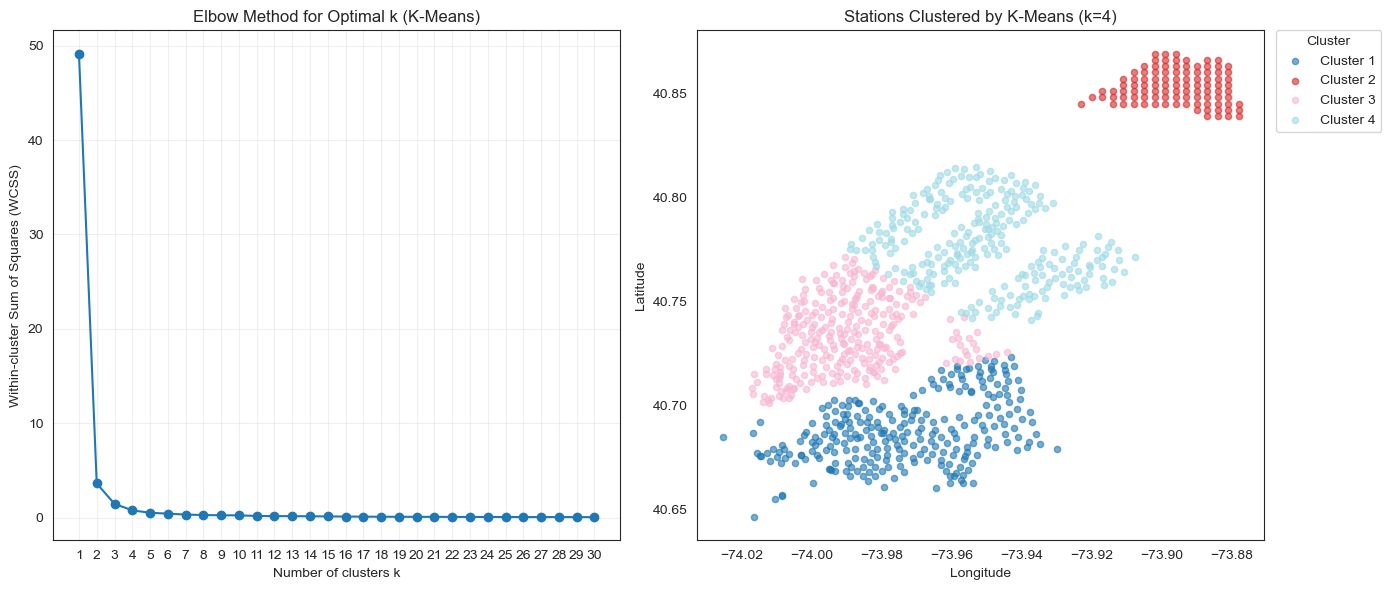

In [124]:
# --- Elbow (left) + K-Means scatter (right) in one figure -------------------

from sklearn.cluster import KMeans
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

# 1) Elbow method ------------------------------------------------------------
def elbow_method(data, max_k):
    """
    Compute within-cluster sum of squares (SSE/WCSS) for k = 1..max_k.
    """
    sse = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_)  # inertia_ = sum of squared distances to centroids
    return sse

coords_for_clustering = stations[['station_longitude', 'station_latitude']]
sse = elbow_method(coords_for_clustering, max_k=30)

# 2) Prepare data + model for k = 4 -----------------------------------------
k = 4  # number of clusters suggested by elbow

# Remove spatial outliers (only for clustering & plotting)
coords = stations[['station_latitude', 'station_longitude']]
z_scores = np.abs(stats.zscore(coords))
mask_no_outliers = (z_scores < 3).all(axis=1)
stations_clean = stations[mask_no_outliers].copy()

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(stations_clean[['station_latitude', 'station_longitude']])
stations_clean['station_cluster'] = kmeans.labels_ + 1  # clusters start at 1

# 3) Create side-by-side plots ----------------------------------------------
fig, (ax_elbow, ax_map) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Elbow plot
ax_elbow.plot(range(1, 31), sse, marker='o')
ax_elbow.set_title('Elbow Method for Optimal k (K-Means)')
ax_elbow.set_xlabel('Number of clusters k')
ax_elbow.set_ylabel('Within-cluster Sum of Squares (WCSS)')
ax_elbow.set_xticks(range(1, 31))
ax_elbow.grid(alpha=0.3)

# Right: K-Means clusters (k = 4)
cmap = plt.cm.get_cmap('tab20', k)
for c in range(1, k + 1):
    m = stations_clean['station_cluster'] == c
    ax_map.scatter(
        stations_clean.loc[m, 'station_longitude'],
        stations_clean.loc[m, 'station_latitude'],
        color=cmap(c - 1),
        alpha=0.6,
        s=20,
        label=f'Cluster {c}'
    )

ax_map.set_title(f'Stations Clustered by K-Means (k={k})')
ax_map.set_xlabel('Longitude')
ax_map.set_ylabel('Latitude')
ax_map.legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()


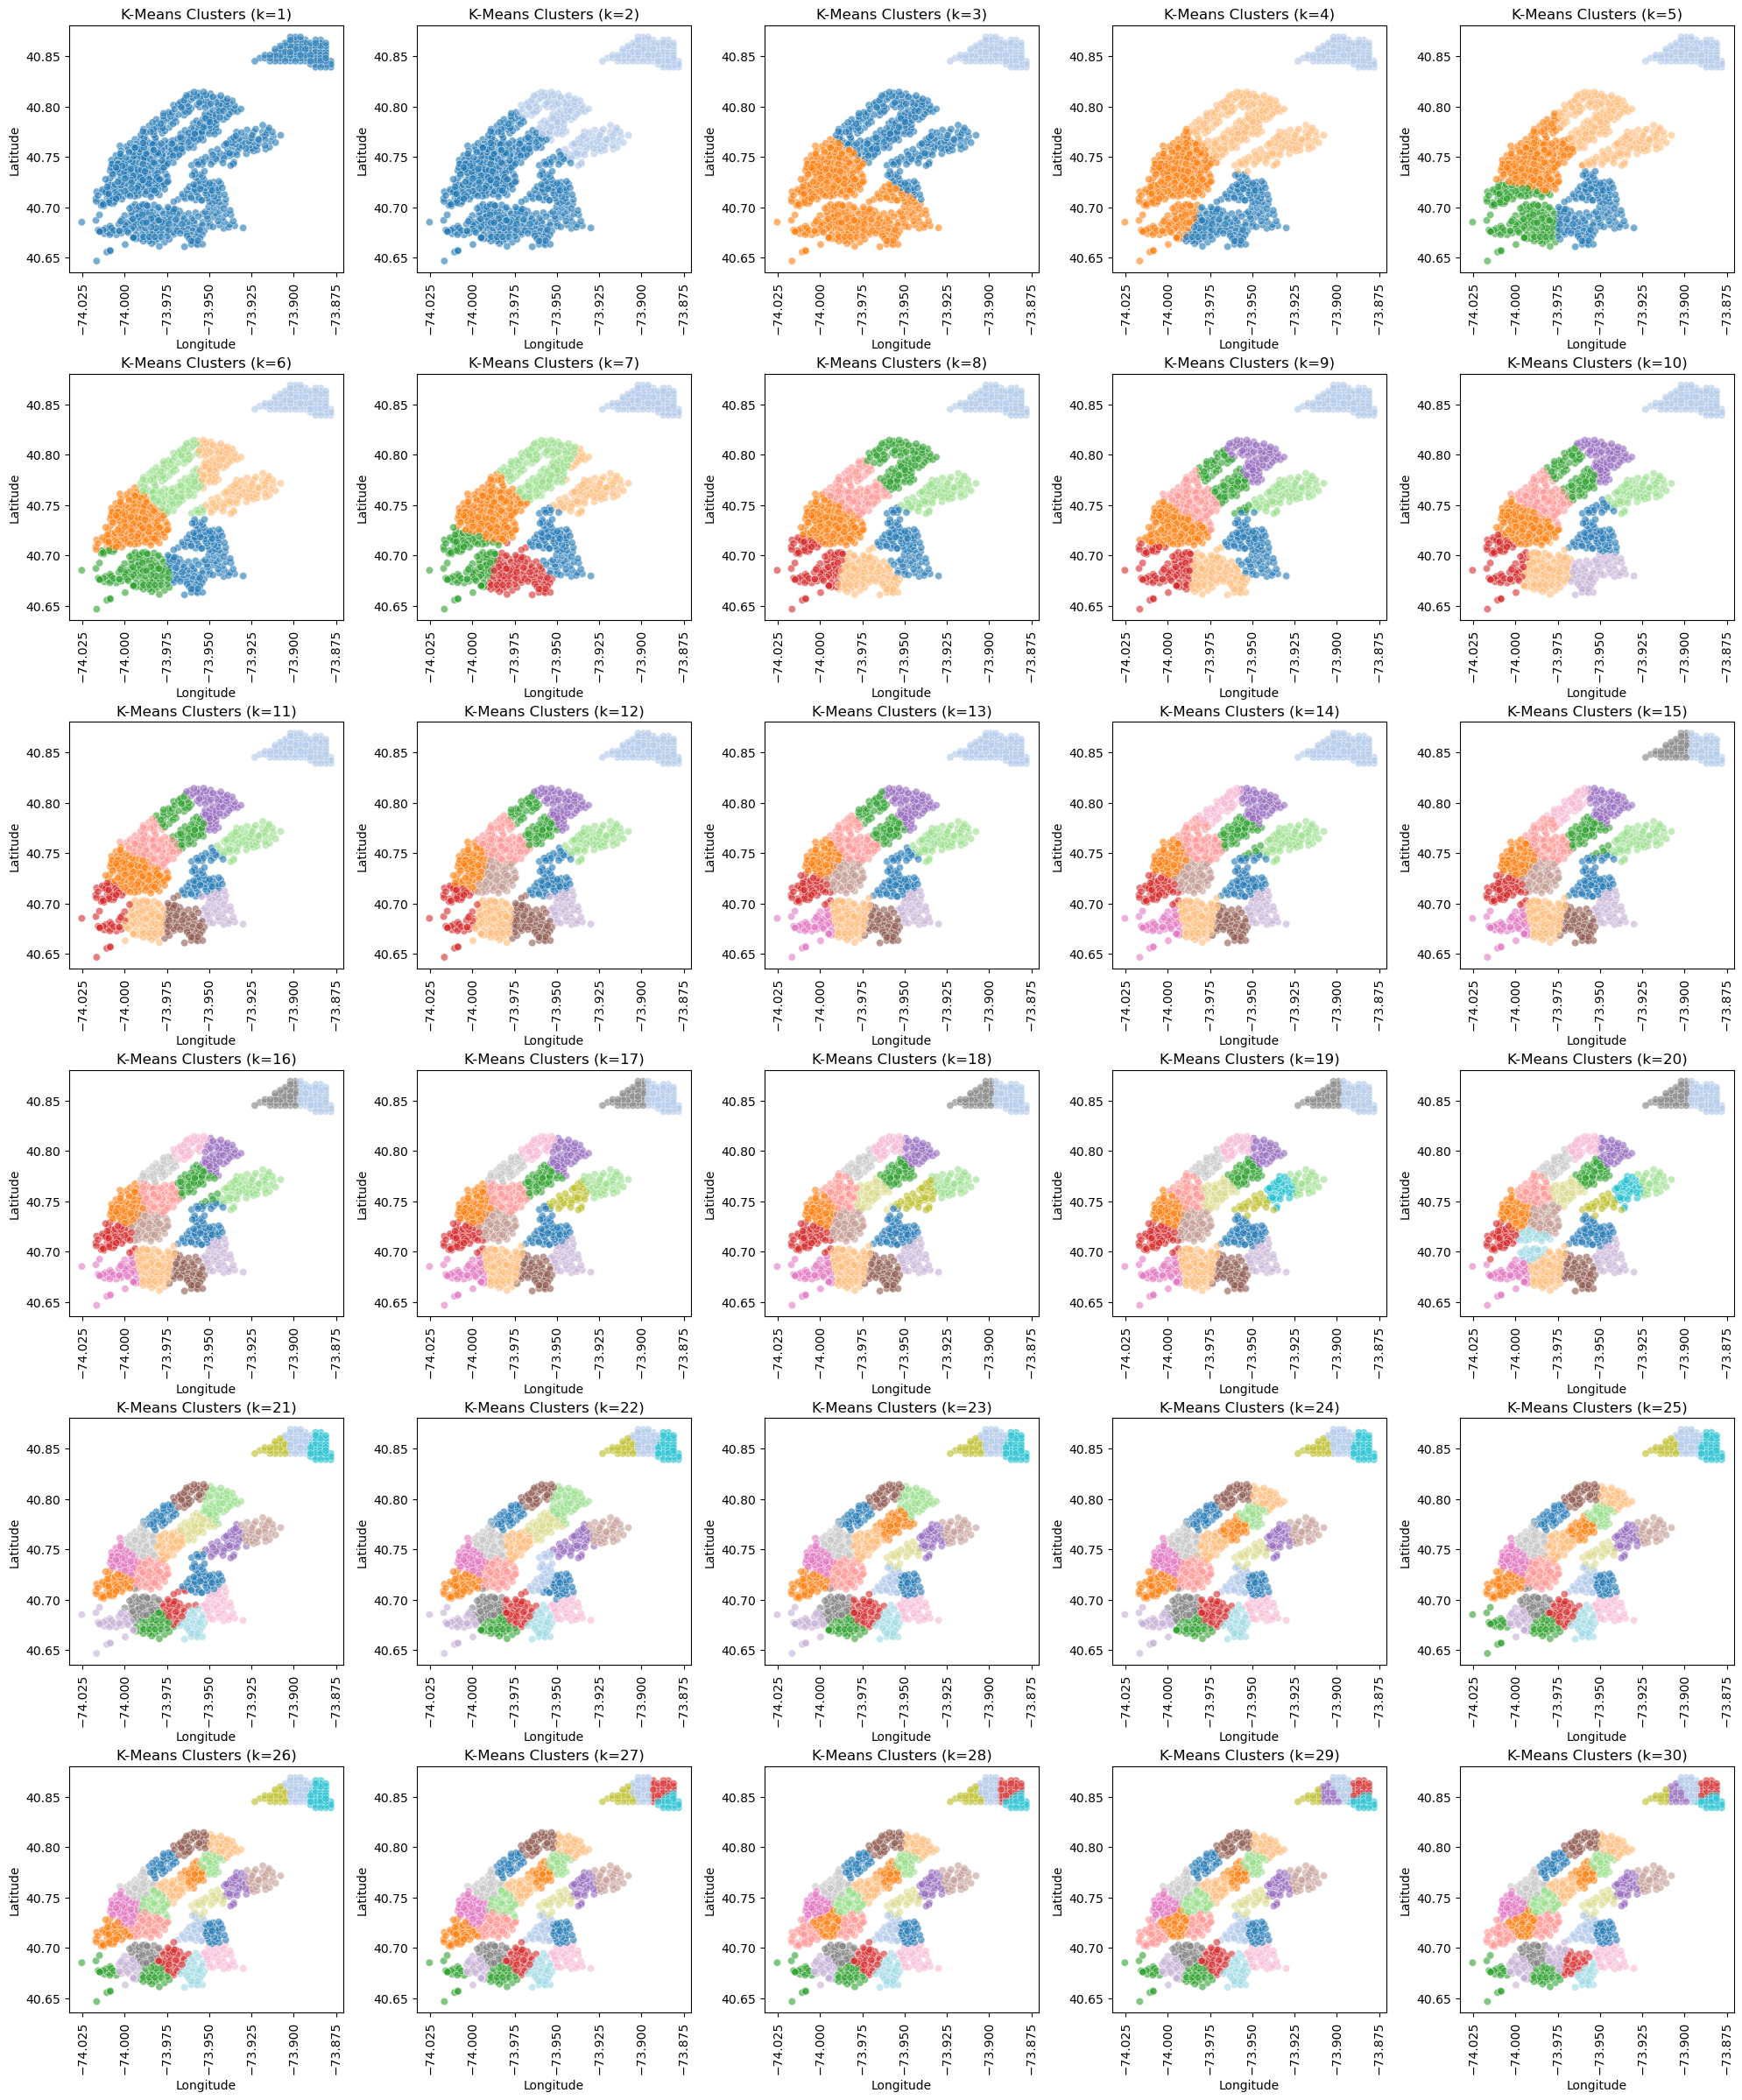

In [ ]:
# --- 8. K-MEANS CLUSTERS FOR k = 1..30 (GRID OF SCATTERPLOTS, OUTLIERS REMOVED) ---
# Chose to visualizae for more k values to see how clusters evolve

from sklearn.preprocessing import StandardScaler
from scipy import stats   # harmless if already imported

# 1) Take only lat/lon and drop missing values
coords = stations[['station_latitude', 'station_longitude']].dropna()

# 2) Detect outliers via z-score and keep points with |z| < 3 in BOTH dimensions
z_scores = np.abs(stats.zscore(coords))
mask_no_outliers = (z_scores < 3).all(axis=1)

# DataFrame for clustering/plotting without spatial outliers
stations_km = stations.loc[mask_no_outliers].copy()

# 3) Standardize lat/lon (normalization to zero mean / unit variance)
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(
    stations_km[['station_latitude', 'station_longitude']]
)

# 4) Grid of scatter plots for k = 1..30  --> 6 rows x 5 columns
fig, ax = plt.subplots(6, 5, figsize=(20, 24))  # 6x5 = 30 subplots

for n_clusters in range(1, 31):    # k = 1..30
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(coords_scaled)                    # fit on standardized data
    stations_km['station_cluster_tmp'] = kmeans.labels_

    # Row/column index in 6x5 grid (5 columns)
    r = (n_clusters - 1) // 5
    c = (n_clusters - 1) % 5

    sns.scatterplot(
        data=stations_km,
        x='station_longitude',                  # original coordinates for map
        y='station_latitude',
        hue='station_cluster_tmp',
        palette='tab20',
        legend=False,
        ax=ax[r, c],
        alpha=0.6
    )
    ax[r, c].set_title(f'K-Means Clusters (k={n_clusters})')
    ax[r, c].set_xlabel('Longitude')
    ax[r, c].set_ylabel('Latitude')

    # Rotate longitude tick labels so they don't overlap
    ax[r, c].tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()

# Clean up temporary column
stations_km.drop(columns=['station_cluster_tmp'], inplace=True)


/var/folders/vt/ws6ct2s14v5839rlq13q46900000gn/T/ipykernel_1288/1277095132.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')  # same palette as scatter plots


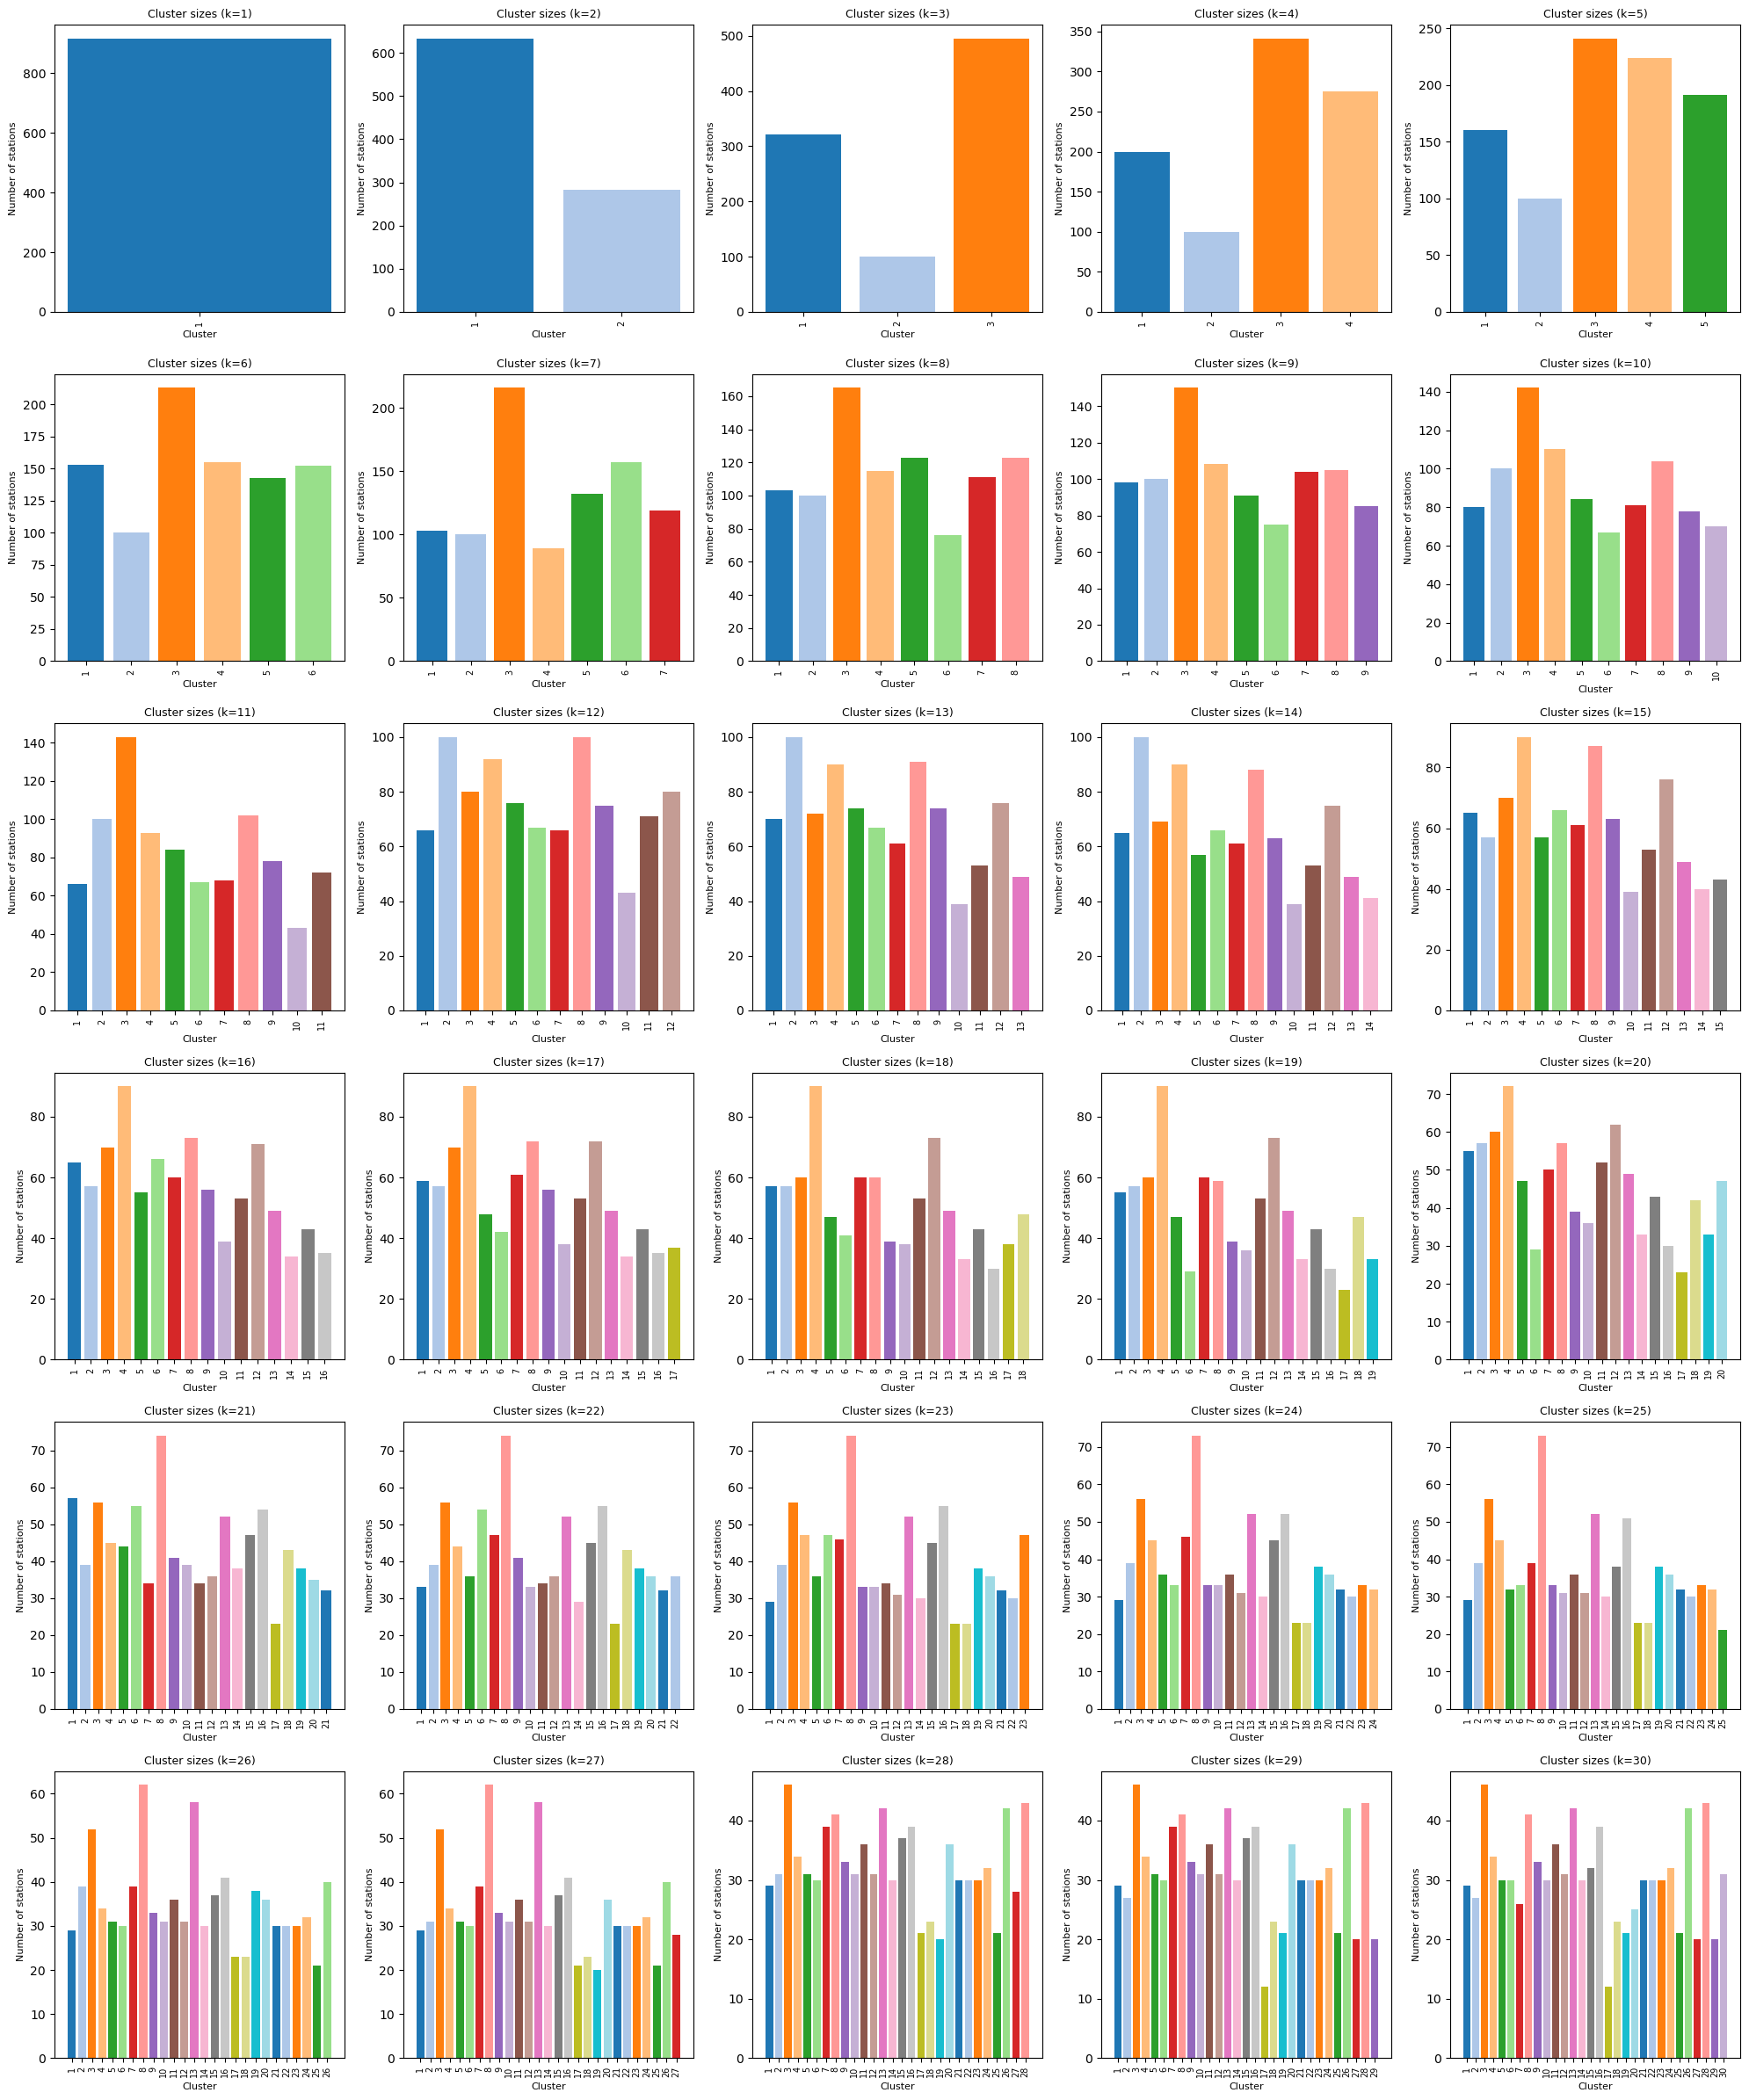

In [109]:
# 9. BAR CHART OF CLUSTER SIZES FOR k = 1..30 -------------------------------

# --- PREP: same data & preprocessing as in your k=1..30 scatter grid -----

# 1) Take only lat/lon and drop missing values
coords = stations[['station_latitude', 'station_longitude']].dropna()

# 2) Remove spatial outliers (|z| < 3 in both dimensions)
z_scores = np.abs(stats.zscore(coords))
mask_no_outliers = (z_scores < 3).all(axis=1)
stations_km = stations.loc[mask_no_outliers].copy()

# 3) Standardize lat/lon for K-Means
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(
    stations_km[['station_latitude', 'station_longitude']]
)

# --- BAR GRID: cluster sizes for k = 1..30 --------------------------------

max_k = 30
fig, axes = plt.subplots(6, 5, figsize=(20, 24))  # 6x5 = 30 subplots
axes = axes.ravel()  # flatten to 1D index for convenience

cmap = plt.cm.get_cmap('tab20')  # same palette as scatter plots

for k in range(1, max_k + 1):
    ax = axes[k-1]

    # Fit K-Means for this k
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(coords_scaled)

    # Count stations per cluster
    cluster_sizes = np.bincount(labels, minlength=k)

    # x positions: 1..k (so first cluster is "1", not "0")
    x = np.arange(1, k + 1)

    # Colors: keep tab20, cycling if k > 20
    colors = [cmap(i % 20) for i in range(k)]

    ax.bar(x, cluster_sizes, color=colors)

    ax.set_title(f'Cluster sizes (k={k})', fontsize=9)
    ax.set_ylabel('Number of stations', fontsize=8)

    # Use cluster numbers 1..k as tick labels, rotated 90°
    ax.set_xticks(x)
    ax.set_xticklabels([str(i) for i in x], rotation=90, fontsize=7)
    ax.set_xlabel('Cluster', fontsize=8)

plt.tight_layout()
plt.show()


## K-Means clustering and plots

/var/folders/vt/ws6ct2s14v5839rlq13q46900000gn/T/ipykernel_1288/339134079.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


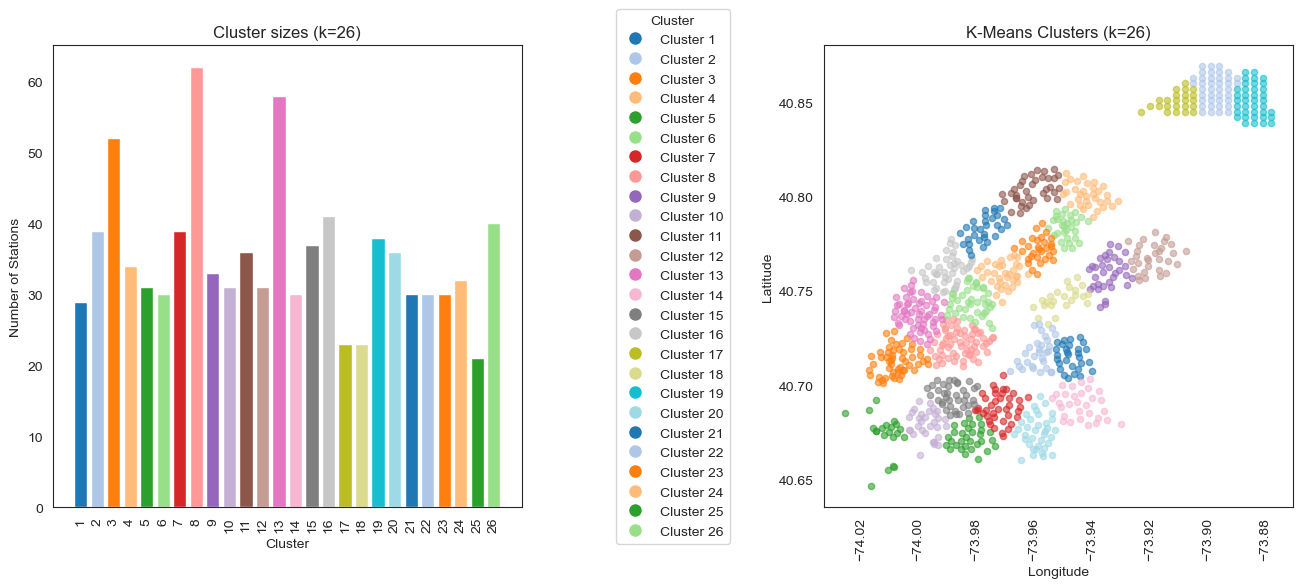

In [128]:
# --- 10. COMBINED FIGURE: CLUSTER SIZES | LEGEND | K-MEANS SCATTER (k = 26) ---

k = 26

# 1) Prepare data: remove outliers and standardize coordinates
coords = stations[['station_latitude', 'station_longitude']].dropna()
z_scores = np.abs(stats.zscore(coords))
mask_no_outliers = (z_scores < 3).all(axis=1)

stations_k26 = stations.loc[mask_no_outliers].copy()

scaler = StandardScaler()
coords_scaled = scaler.fit_transform(
    stations_k26[['station_latitude', 'station_longitude']]
)

# 2) Fit K-Means with k = 26
kmeans = KMeans(n_clusters=k, random_state=42)
stations_k26['cluster_k26'] = kmeans.fit_predict(coords_scaled)

# 3) Shared color palette for all three elements
palette = sns.color_palette('tab20', k)
color_map = {c: palette[c] for c in range(k)}

# Cluster sizes for bar chart
sizes = stations_k26.groupby('cluster_k26').size().sort_index()
clusters_1based = sizes.index + 1

# 4) Figure with three panels: bar | legend | scatter
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 0.8, 3], wspace=0.25)

ax_bar     = fig.add_subplot(gs[0, 0])  # LEFT  : cluster sizes
ax_legend  = fig.add_subplot(gs[0, 1])  # MIDDLE: legend
ax_scatter = fig.add_subplot(gs[0, 2])  # RIGHT : k-means scatter

# --- Left: cluster-size bar chart (same colors) ---
bar_colors = [color_map[c] for c in sizes.index]

ax_bar.bar(clusters_1based, sizes.values, color=bar_colors)
ax_bar.set_title(f'Cluster sizes (k={k})')
ax_bar.set_xlabel('Cluster')
ax_bar.set_ylabel('Number of Stations')

# show *every* cluster label on the x-axis (1, 2, 3, ..., 26)
ax_bar.set_xticks(clusters_1based)
ax_bar.set_xticklabels([str(c) for c in clusters_1based])

for tick in ax_bar.get_xticklabels():
    tick.set_rotation(90)

# --- Middle: legend with round markers (keep border) ---
ax_legend.axis('off')

legend_handles = [
    Line2D(
        [0], [0],
        marker='o',
        linestyle='',
        markersize=8,
        markerfacecolor=color_map[c],
        markeredgecolor=color_map[c]
    )
    for c in range(k)
]
legend_labels = [f'Cluster {c+1}' for c in range(k)]

leg = ax_legend.legend(
    legend_handles,
    legend_labels,
    title='Cluster',
    loc='center',
    frameon=True  # keep border
)
leg.get_frame().set_facecolor('white')

# --- Right: K-Means scatter plot ---
for c in range(k):
    m = stations_k26['cluster_k26'] == c
    ax_scatter.scatter(
        stations_k26.loc[m, 'station_longitude'],
        stations_k26.loc[m, 'station_latitude'],
        color=color_map[c],
        s=20,
        alpha=0.6
    )

ax_scatter.set_title(f'K-Means Clusters (k={k})')
ax_scatter.set_xlabel('Longitude')
ax_scatter.set_ylabel('Latitude')
for tick in ax_scatter.get_xticklabels():
    tick.set_rotation(90)

plt.tight_layout()
plt.show()


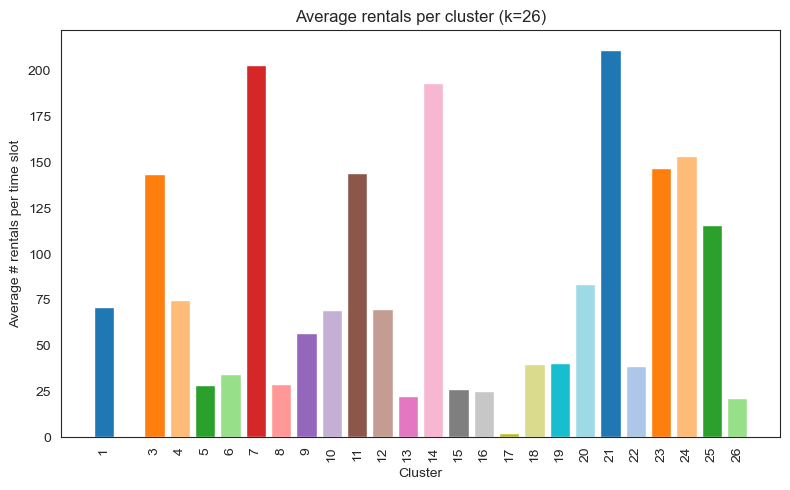

In [141]:
# --- 11. BAR CHART: AVG RENTALS PER CLUSTER (k = 26) ------------------------
# k = 26, palette as before
k = 26
palette = sns.color_palette('tab20', k)

# Make color_map 1-based: keys 1..26
color_map = {c+1: palette[c] for c in range(k)}

# avg_bikes_per_cluster as you computed it earlier
# station_cluster is already 1..26, so no +1 needed
clusters_1based = avg_bikes_per_cluster['station_cluster']

# Colors for each bar using the 1-based map
bar_colors = [color_map[c] for c in clusters_1based]

plt.figure(figsize=(8, 5))
plt.bar(
    clusters_1based,
    avg_bikes_per_cluster['avg_num_rentals'],
    color=bar_colors
)
plt.xlabel('Cluster')
plt.ylabel('Average # rentals per time slot')
plt.title('Average rentals per cluster (k=26)')
plt.xticks(clusters_1based, rotation=90)
plt.tight_layout()
plt.show()


In [143]:
# --- 14. FOCUS ON THE BUSIEST CLUSTER -------------------------------------

busiest_cluster_id = int(avg_bikes_per_cluster.iloc[0]['station_cluster'])
print("Busiest cluster:", busiest_cluster_id)

cluster_data = data[data['station_cluster'] == busiest_cluster_id].copy()

# Ensure the datetime/day/hour columns exist on cluster_data
cluster_data['pickup_datetime'] = pd.to_datetime(cluster_data['starttime'])
cluster_data['pickup_day'] = cluster_data['pickup_datetime'].dt.date
cluster_data['pickup_hour'] = cluster_data['pickup_datetime'].dt.hour

cluster_data['dropoff_datetime'] = pd.to_datetime(cluster_data['stoptime'])
cluster_data['dropoff_day'] = cluster_data['dropoff_datetime'].dt.date
cluster_data['dropoff_hour'] = cluster_data['dropoff_datetime'].dt.hour

# Hourly pickups and dropoffs within that cluster
hourly_pickups_cluster = (
    cluster_data
    .groupby(['pickup_datetime', 'pickup_day', 'pickup_hour'])['bikeid']
    .size()
    .reset_index(name='num_rentals')
)

hourly_dropoffs_cluster = (
    cluster_data
    .groupby(['dropoff_datetime', 'dropoff_day', 'dropoff_hour'])['bikeid']
    .size()
    .reset_index(name='num_rentals')
)

hourly_pickups_cluster.head()


Busiest cluster: 21


,pickup_datetime,pickup_day,pickup_hour,num_rentals


In [144]:
# --- 15. FILL MISSING HOURS WITH ZERO RENTALS ------------------------------

def fill_missing_hours(df):
    """
    Assumes df has columns:
        'pickup_datetime', 'pickup_day', 'pickup_hour', 'num_rentals'
    Returns a DataFrame with a complete hourly grid where missing hours have
    num_rentals = 0.
    """
    start = df['pickup_datetime'].min().floor('H')
    end   = df['pickup_datetime'].max().ceil('H')

    all_hours = pd.date_range(start=start, end=end, freq='H')
    all_df = pd.DataFrame({'pickup_datetime': all_hours})
    all_df['pickup_day'] = all_df['pickup_datetime'].dt.date
    all_df['pickup_hour'] = all_df['pickup_datetime'].dt.hour

    merged = pd.merge(
        all_df,
        df[['pickup_datetime', 'num_rentals']],
        on='pickup_datetime',
        how='left'
    )
    merged['num_rentals'] = merged['num_rentals'].fillna(0).astype(int)
    return merged

hourly_pickups_cluster = fill_missing_hours(hourly_pickups_cluster)

print("Shape after filling:", hourly_pickups_cluster.shape)
hourly_pickups_cluster.head()


/var/folders/vt/ws6ct2s14v5839rlq13q46900000gn/T/ipykernel_1288/449815643.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  all_hours = pd.date_range(start=start, end=end, freq='H')


ValueError: Neither `start` nor `end` can be NaT

In [145]:
# --- 16. TRAIN / TEST SPLIT FOR TIME SERIES --------------------------------

END_TRAINING_DATE = pd.to_datetime("2018-10-31")

hourly_pickups_cluster['pickup_day'] = pd.to_datetime(hourly_pickups_cluster['pickup_day'])

train_data = hourly_pickups_cluster[hourly_pickups_cluster['pickup_day'] <= END_TRAINING_DATE].copy()
test_data  = hourly_pickups_cluster[hourly_pickups_cluster['pickup_day'] >  END_TRAINING_DATE].copy()

train_data = train_data.set_index('pickup_datetime')
test_data  = test_data.set_index('pickup_datetime')

train_data.index = pd.to_datetime(train_data.index)
test_data.index  = pd.to_datetime(test_data.index)

print("Train shape:", train_data.shape, "Test shape:", test_data.shape)


Train shape: (0, 3) Test shape: (0, 3)


In [146]:
# --- 17. FIT ARIMA MODEL (BASELINE) ----------------------------------------

# Simple AR(24) model as in your original attempt
model = ARIMA(train_data['num_rentals'], order=(24, 0, 0))
model_fit = model.fit()
print(model_fit.summary())


ValueError: zero-size array to reduction operation maximum which has no identity

MAE:  0.00
RMSE: 0.00


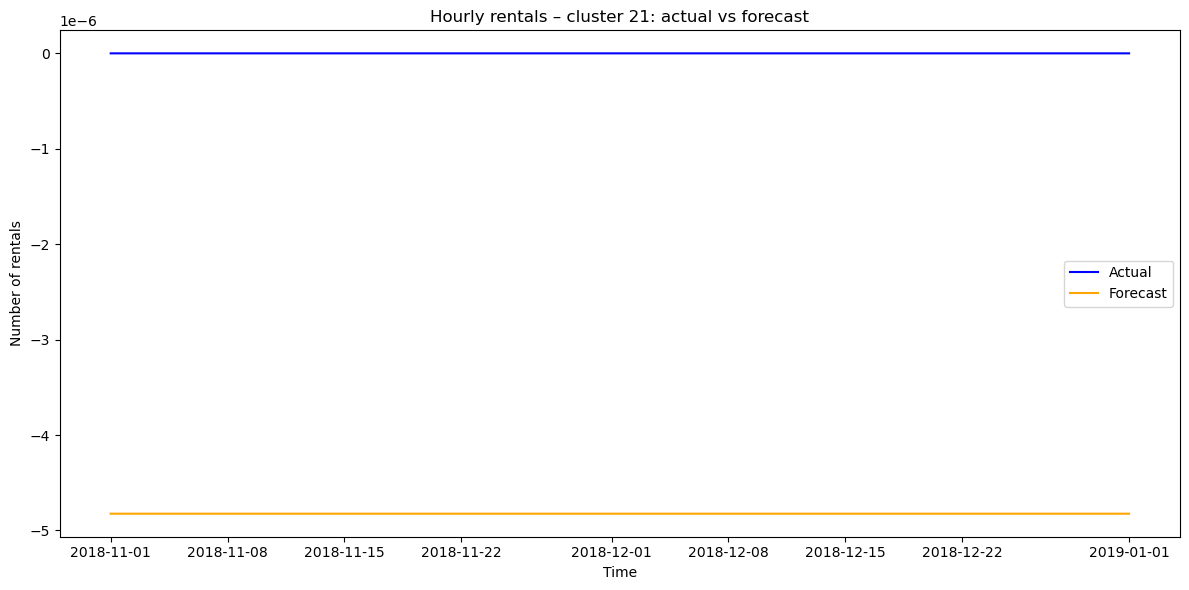

In [51]:
# --- 18. FORECAST AND EVALUATE ---------------------------------------------

n_steps = len(test_data)
predictions = model_fit.forecast(steps=n_steps)

test_data = test_data.copy()
test_data['predicted_num_rentals'] = predictions.values

mae = mean_absolute_error(test_data['num_rentals'], test_data['predicted_num_rentals'])
mse = mean_squared_error(test_data['num_rentals'], test_data['predicted_num_rentals'])
rmse = np.sqrt(mse)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['num_rentals'], label='Actual', color='blue')
plt.plot(test_data.index, test_data['predicted_num_rentals'], label='Forecast', color='orange')
plt.title(f'Hourly rentals – cluster {busiest_cluster_id}: actual vs forecast')
plt.ylabel('Number of rentals')
plt.xlabel('Time')
plt.legend()
plt.tight_layout()
plt.show()
